In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

In [14]:
df = pd.read_csv('Iris.csv')
df = df.drop("Id", axis=1)
df.head(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [15]:
X = df.drop('Species', axis=1).values
y = df['Species'].values

In [16]:
le = LabelEncoder()
y = le.fit_transform(y)  

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.5, random_state=42)

In [20]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

In [21]:
class IrisMLP(nn.Module):
    def __init__(self):
        super(IrisMLP,self).__init__()
        self.fc1 = nn.Linear(4,8)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(8,3)

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
model = IrisMLP()

In [22]:
#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [23]:
num_epochs = 5  # Rename to avoid collision

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


In [24]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X,batch_y in test_loader:
        outputs = model(batch_X)
        _,predicted = torch.max(outputs.data,1)
        total +=batch_y.size(0)
        correct += (predicted==batch_y).sum().item()
print(f"\n Test Accuracy:{100*correct/total:.2f}%")


 Test Accuracy:89.33%



Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        29
Iris-versicolor       0.89      0.74      0.81        23
 Iris-virginica       0.78      0.91      0.84        23

       accuracy                           0.89        75
      macro avg       0.89      0.88      0.88        75
   weighted avg       0.90      0.89      0.89        75



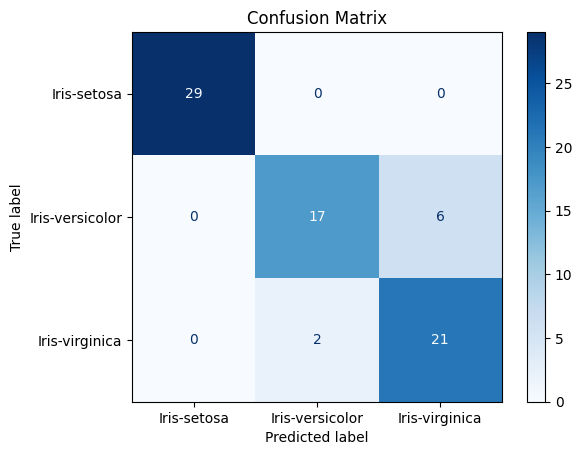

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Collect all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(batch_y.numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
